In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import tqdm

import lightgbm as lgb

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Данные

In [3]:
df = pd.read_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/all_data.parquet', 
                  index=False, engine='fastparquet')

In [4]:
df

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,fclose_flag_1,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,flag
0,0,0,1,1,1,1,2,0,1,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,1,0,0,0,0,1,2,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,1,0,0,0,0,0,0,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0,3,1,0,2,1,3,0,0,...,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0,0,0,0,0,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,1,2,0,0,2,0,1,0,0,...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999996,2999996,0,1,0,1,1,5,0,0,1,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999997,2999997,0,0,1,1,3,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999998,2999998,0,0,0,0,1,0,0,1,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Разделим выборку на test и train

In [5]:
def split(data):
    X = data.drop('flag', axis=1)
    y = data['flag']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(df)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100000, 420), (900000, 420), (2100000,), (900000,))

In [16]:
X = df.drop('flag', axis=1)
y = df['flag']

## Baseline

In [13]:
model_lgbm = lgb.LGBMClassifier(
    n_estimators=10,
    metric='AUC',
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=1,
    num_leaves=64,
    n_jobs=5
)

In [9]:
model_lgbm.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=10,
    verbose=1
)

[1]	valid_0's auc: 0.664978
[2]	valid_0's auc: 0.695408
[3]	valid_0's auc: 0.70048
[4]	valid_0's auc: 0.708428
[5]	valid_0's auc: 0.713332
[6]	valid_0's auc: 0.717775
[7]	valid_0's auc: 0.720951
[8]	valid_0's auc: 0.722526
[9]	valid_0's auc: 0.724496
[10]	valid_0's auc: 0.72637


LGBMClassifier(max_depth=5, metric='AUC', n_estimators=10, n_jobs=5,
               num_leaves=64, reg_lambda=1)

In [9]:
print('Model params: ')
print(model_lgbm.get_params())

Model params: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': 5, 'num_leaves': 64, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 1, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'AUC'}


In [10]:
print("Best Score: \n", model_lgbm.best_score_)

Best Score: 
 defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7263700801514483)])})


In [11]:
model_lgbm.evals_result_['valid_0']['auc']

[0.6649776597193612,
 0.6954076747813056,
 0.700479995883709,
 0.7084280016446982,
 0.7133317968628857,
 0.7177754683275237,
 0.720950610157964,
 0.7225255906764219,
 0.7244964111642268,
 0.7263700801514483]

In [34]:
df_score_lgb = pd.DataFrame()

df_score_lgb['iter'] = [i for i in range(0, len(model_lgbm.evals_result_['valid_0']['auc']))]
df_score_lgb['score'] = model_lgbm.evals_result_['valid_0']['auc']

In [35]:
df_score_lgb.head()

,iter,score
0,0,0.664978
1,1,0.695408
2,2,0.700480
3,3,0.708428
4,4,0.713332


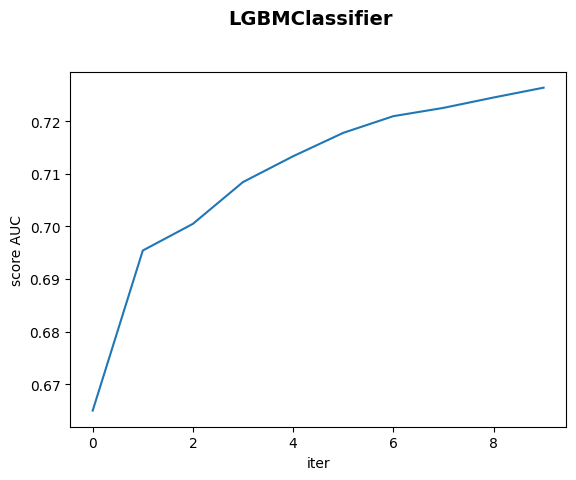

In [36]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('LGBMClassifier', fontsize=14, fontweight='bold')

ax.set_xlabel('iter')
ax.set_ylabel('score AUC')

ax.plot(df_score_lgb['iter'], df_score_lgb['score'])

### Feature importance

In [10]:
feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

In [13]:
feature_imp.sort_values(by="Value", ascending=False)[:60]

,Value,Feature
419,33,pre_util_3
418,26,pre_util_6
417,18,is_zero_loans3060_0
416,14,pre_till_pclose_10
415,13,enc_loans_credit_type_0
414,12,pre_since_opened_12
413,12,enc_paym_0_1
412,11,enc_loans_credit_status_5
411,9,is_zero_loans530_0
410,7,is_zero_loans90_0


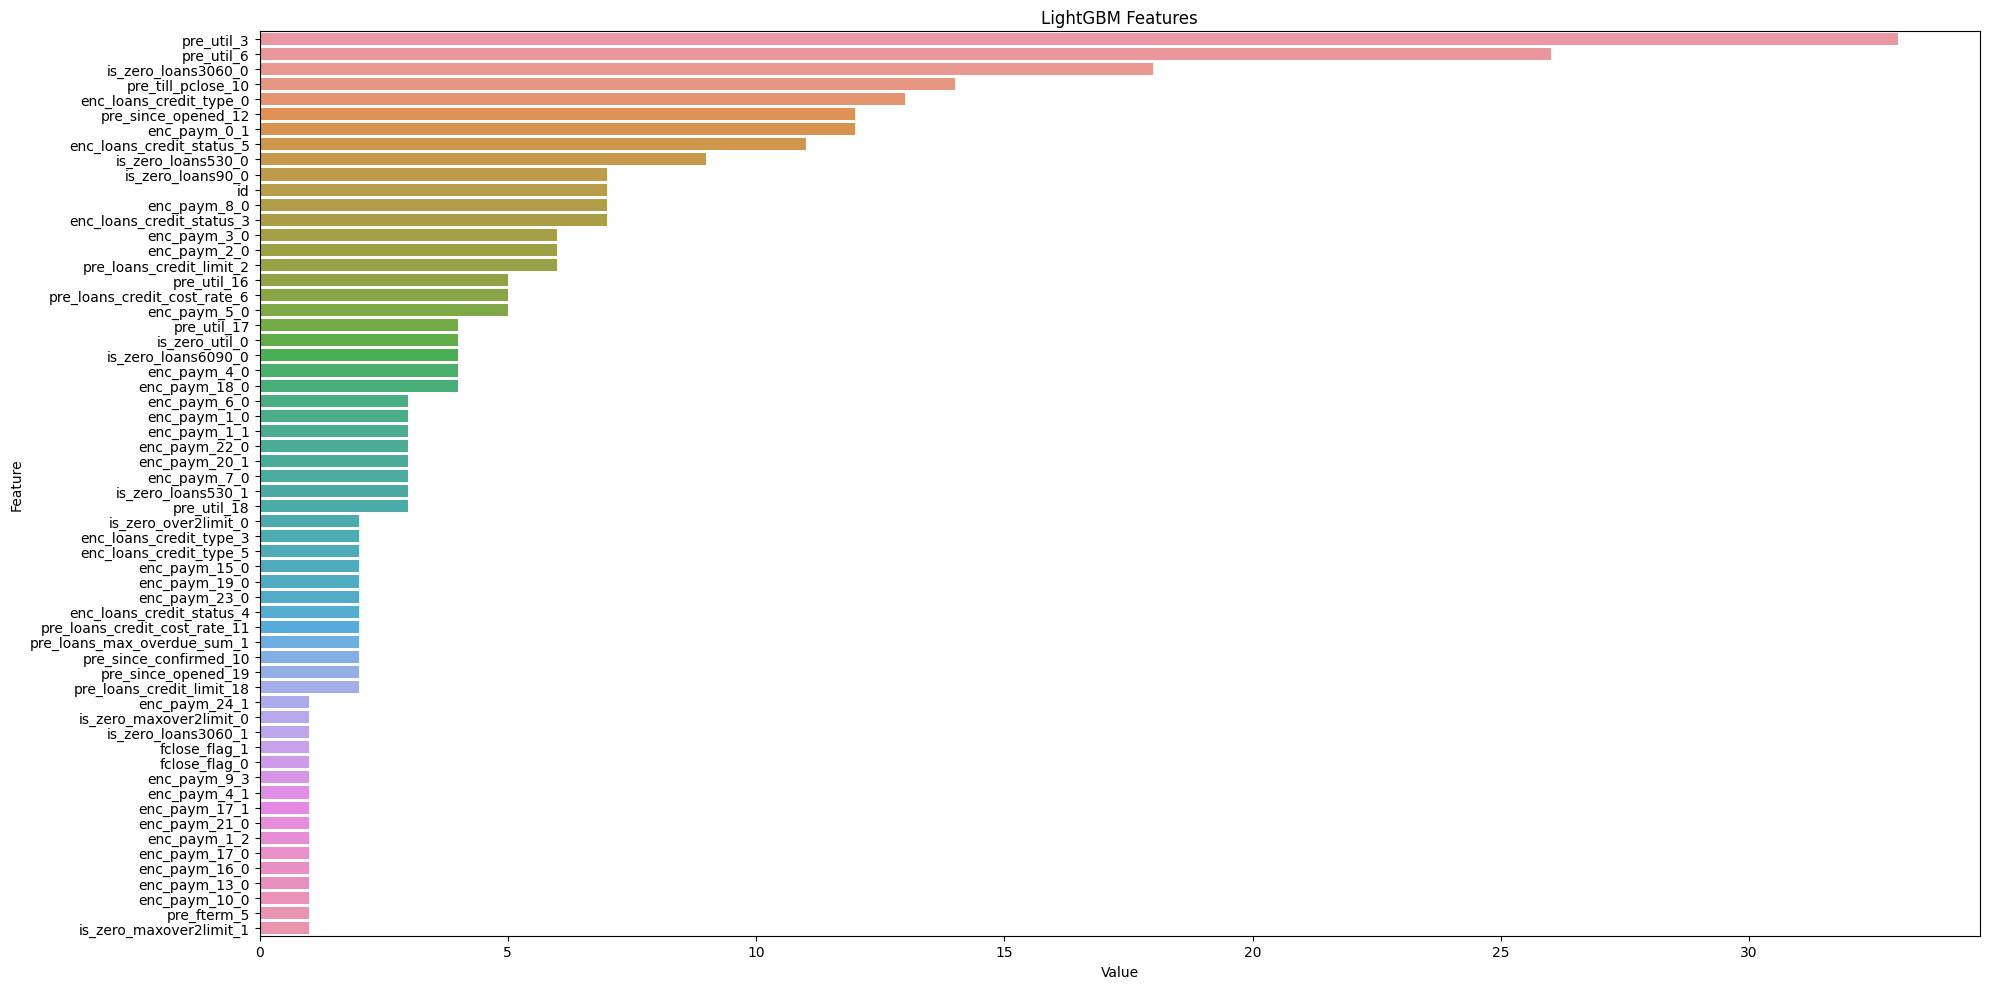

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:60])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [17]:
feature_imp.loc[feature_imp['Value'] == 0]

,Value,Feature
0,0,enc_loans_account_cur_0
1,0,enc_loans_account_cur_1
2,0,enc_loans_account_cur_2
3,0,enc_loans_account_cur_3
4,0,enc_loans_account_holder_type_0
...,...,...
338,0,pre_util_4
339,0,pre_util_5
340,0,pre_util_7
341,0,pre_util_8


In [18]:
X_train_new = X_train.drop(list(feature_imp.loc[feature_imp['Value'] == 0]['Feature']), 
                           axis = 1)

In [19]:
X_test_new = X_test.drop(list(feature_imp.loc[feature_imp['Value'] == 0]['Feature']), 
                           axis = 1)

In [9]:
model_lgbm_new = lgb.LGBMClassifier(
    n_estimators=10,
    metric='AUC',
    learning_rate=0.1,
    max_depth=6,
    reg_lambda=1,
    num_leaves=64,
    n_jobs=5
)

In [23]:
model_lgbm_new.fit(
    X_train_new, y_train,
    eval_set=(X_test_new, y_test),
    early_stopping_rounds=10,
    verbose=1
)

[1]	valid_0's auc: 0.664978
[2]	valid_0's auc: 0.695408
[3]	valid_0's auc: 0.70048
[4]	valid_0's auc: 0.708428
[5]	valid_0's auc: 0.713332
[6]	valid_0's auc: 0.717775
[7]	valid_0's auc: 0.720951
[8]	valid_0's auc: 0.722526
[9]	valid_0's auc: 0.724496
[10]	valid_0's auc: 0.72637


LGBMClassifier(max_depth=5, metric='AUC', n_estimators=10, n_jobs=5,
               num_leaves=64, reg_lambda=1)

### GridSearchCV

In [8]:
model_lgbm_gc = lgb.LGBMClassifier(
    metric='AUC'
)

In [9]:
params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 6],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'random_state' : [501], 
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }

In [10]:
random = RandomizedSearchCV(model_lgbm_gc, params,verbose=1, cv=3,scoring='roc_auc')

In [11]:
random.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[1]	valid_0's auc: 0.670883	valid_1's auc: 0.673544
[2]	valid_0's auc: 0.670884	valid_1's auc: 0.673548
[3]	valid_0's auc: 0.671036	valid_1's auc: 0.673749
[4]	valid_0's auc: 0.673573	valid_1's auc: 0.676302
[5]	valid_0's auc: 0.674193	valid_1's auc: 0.676704
[6]	valid_0's auc: 0.687049	valid_1's auc: 0.689294
[7]	valid_0's auc: 0.690188	valid_1's auc: 0.692338
[8]	valid_0's auc: 0.692918	valid_1's auc: 0.694764
[9]	valid_0's auc: 0.694752	valid_1's auc: 0.696285
[10]	valid_0's auc: 0.696491	valid_1's auc: 0.698176
[11]	valid_0's auc: 0.697023	valid_1's auc: 0.698558
[12]	valid_0's auc: 0.697049	valid_1's auc: 0.698697
[13]	valid_0's auc: 0.697597	valid_1's auc: 0.699157
[14]	valid_0's auc: 0.697782	valid_1's auc: 0.699261
[15]	valid_0's auc: 0.697999	valid_1's auc: 0.699416
[16]	valid_0's auc: 0.698228	va

[51]	valid_0's auc: 0.716937	valid_1's auc: 0.717057
[52]	valid_0's auc: 0.71723	valid_1's auc: 0.717352
[53]	valid_0's auc: 0.71757	valid_1's auc: 0.717695
[54]	valid_0's auc: 0.717959	valid_1's auc: 0.718078
[55]	valid_0's auc: 0.718478	valid_1's auc: 0.718519
[56]	valid_0's auc: 0.718901	valid_1's auc: 0.71893
[57]	valid_0's auc: 0.719057	valid_1's auc: 0.719093
[58]	valid_0's auc: 0.719411	valid_1's auc: 0.71944
[59]	valid_0's auc: 0.719798	valid_1's auc: 0.719801
[60]	valid_0's auc: 0.720227	valid_1's auc: 0.720189
[61]	valid_0's auc: 0.720365	valid_1's auc: 0.720333
[62]	valid_0's auc: 0.720651	valid_1's auc: 0.720596
[63]	valid_0's auc: 0.720973	valid_1's auc: 0.720916
[64]	valid_0's auc: 0.721243	valid_1's auc: 0.721182
[65]	valid_0's auc: 0.721503	valid_1's auc: 0.721424
[66]	valid_0's auc: 0.721812	valid_1's auc: 0.721726
[67]	valid_0's auc: 0.722131	valid_1's auc: 0.722008
[68]	valid_0's auc: 0.722402	valid_1's auc: 0.722258
[69]	valid_0's auc: 0.722631	valid_1's auc: 0.7224

[2]	valid_0's auc: 0.704606	valid_1's auc: 0.705346
[3]	valid_0's auc: 0.708909	valid_1's auc: 0.709517
[4]	valid_0's auc: 0.715435	valid_1's auc: 0.715592
[5]	valid_0's auc: 0.720727	valid_1's auc: 0.720682
[6]	valid_0's auc: 0.722204	valid_1's auc: 0.721868
[7]	valid_0's auc: 0.72651	valid_1's auc: 0.726001
[8]	valid_0's auc: 0.728706	valid_1's auc: 0.727688
[9]	valid_0's auc: 0.730998	valid_1's auc: 0.729668
[10]	valid_0's auc: 0.732207	valid_1's auc: 0.730572
[11]	valid_0's auc: 0.734183	valid_1's auc: 0.732159
[12]	valid_0's auc: 0.735756	valid_1's auc: 0.733486
[13]	valid_0's auc: 0.737356	valid_1's auc: 0.734904
[14]	valid_0's auc: 0.738733	valid_1's auc: 0.735957
[15]	valid_0's auc: 0.739554	valid_1's auc: 0.736496
[16]	valid_0's auc: 0.740906	valid_1's auc: 0.737694
[17]	valid_0's auc: 0.741846	valid_1's auc: 0.738421
[18]	valid_0's auc: 0.743098	valid_1's auc: 0.739473
[19]	valid_0's auc: 0.74414	valid_1's auc: 0.740239
[20]	valid_0's auc: 0.745192	valid_1's auc: 0.741048
[21

[56]	valid_0's auc: 0.764148	valid_1's auc: 0.75326
[57]	valid_0's auc: 0.764439	valid_1's auc: 0.753443
[58]	valid_0's auc: 0.764748	valid_1's auc: 0.753566
[59]	valid_0's auc: 0.765069	valid_1's auc: 0.753752
[60]	valid_0's auc: 0.765382	valid_1's auc: 0.753891
[61]	valid_0's auc: 0.765631	valid_1's auc: 0.753954
[62]	valid_0's auc: 0.765981	valid_1's auc: 0.754133
[63]	valid_0's auc: 0.766343	valid_1's auc: 0.75438
[64]	valid_0's auc: 0.766713	valid_1's auc: 0.754599
[65]	valid_0's auc: 0.766914	valid_1's auc: 0.754702
[66]	valid_0's auc: 0.767111	valid_1's auc: 0.754837
[67]	valid_0's auc: 0.767421	valid_1's auc: 0.755033
[68]	valid_0's auc: 0.767593	valid_1's auc: 0.755114
[69]	valid_0's auc: 0.767849	valid_1's auc: 0.755191
[70]	valid_0's auc: 0.768067	valid_1's auc: 0.755297
[71]	valid_0's auc: 0.768319	valid_1's auc: 0.755395
[72]	valid_0's auc: 0.768529	valid_1's auc: 0.75546
[73]	valid_0's auc: 0.768812	valid_1's auc: 0.755546
[74]	valid_0's auc: 0.768983	valid_1's auc: 0.755

[7]	valid_0's auc: 0.72651	valid_1's auc: 0.726001
[8]	valid_0's auc: 0.728706	valid_1's auc: 0.727688
[9]	valid_0's auc: 0.730998	valid_1's auc: 0.729668
[10]	valid_0's auc: 0.732207	valid_1's auc: 0.730572
[11]	valid_0's auc: 0.734183	valid_1's auc: 0.732159
[12]	valid_0's auc: 0.735756	valid_1's auc: 0.733486
[13]	valid_0's auc: 0.737356	valid_1's auc: 0.734904
[14]	valid_0's auc: 0.738733	valid_1's auc: 0.735957
[15]	valid_0's auc: 0.739554	valid_1's auc: 0.736496
[16]	valid_0's auc: 0.740906	valid_1's auc: 0.737694
[17]	valid_0's auc: 0.741846	valid_1's auc: 0.738421
[18]	valid_0's auc: 0.743098	valid_1's auc: 0.739473
[19]	valid_0's auc: 0.74414	valid_1's auc: 0.740239
[20]	valid_0's auc: 0.745192	valid_1's auc: 0.741048
[21]	valid_0's auc: 0.746095	valid_1's auc: 0.741845
[22]	valid_0's auc: 0.747108	valid_1's auc: 0.74262
[23]	valid_0's auc: 0.747771	valid_1's auc: 0.743112
[24]	valid_0's auc: 0.748469	valid_1's auc: 0.743577
[25]	valid_0's auc: 0.74926	valid_1's auc: 0.744215


[61]	valid_0's auc: 0.765631	valid_1's auc: 0.753954
[62]	valid_0's auc: 0.765981	valid_1's auc: 0.754133
[63]	valid_0's auc: 0.766343	valid_1's auc: 0.75438
[64]	valid_0's auc: 0.766713	valid_1's auc: 0.754599
[65]	valid_0's auc: 0.766914	valid_1's auc: 0.754702
[66]	valid_0's auc: 0.767111	valid_1's auc: 0.754837
[67]	valid_0's auc: 0.767421	valid_1's auc: 0.755033
[68]	valid_0's auc: 0.767593	valid_1's auc: 0.755114
[69]	valid_0's auc: 0.767849	valid_1's auc: 0.755191
[70]	valid_0's auc: 0.768067	valid_1's auc: 0.755297
[71]	valid_0's auc: 0.768319	valid_1's auc: 0.755395
[72]	valid_0's auc: 0.768529	valid_1's auc: 0.75546
[73]	valid_0's auc: 0.768812	valid_1's auc: 0.755546
[74]	valid_0's auc: 0.768983	valid_1's auc: 0.755606
[75]	valid_0's auc: 0.769184	valid_1's auc: 0.755662
[76]	valid_0's auc: 0.769441	valid_1's auc: 0.755752
[77]	valid_0's auc: 0.769695	valid_1's auc: 0.755835
[78]	valid_0's auc: 0.769894	valid_1's auc: 0.755952
[79]	valid_0's auc: 0.770088	valid_1's auc: 0.75

[13]	valid_0's auc: 0.697597	valid_1's auc: 0.699157
[14]	valid_0's auc: 0.697782	valid_1's auc: 0.699261
[15]	valid_0's auc: 0.697999	valid_1's auc: 0.699416
[16]	valid_0's auc: 0.698228	valid_1's auc: 0.699648
[17]	valid_0's auc: 0.698619	valid_1's auc: 0.700053
[18]	valid_0's auc: 0.699124	valid_1's auc: 0.700501
[19]	valid_0's auc: 0.699046	valid_1's auc: 0.700491
[20]	valid_0's auc: 0.700466	valid_1's auc: 0.701784
[21]	valid_0's auc: 0.700442	valid_1's auc: 0.701691
[22]	valid_0's auc: 0.701088	valid_1's auc: 0.702237
[23]	valid_0's auc: 0.703219	valid_1's auc: 0.704426
[24]	valid_0's auc: 0.703546	valid_1's auc: 0.70465
[25]	valid_0's auc: 0.703682	valid_1's auc: 0.704803
[26]	valid_0's auc: 0.703739	valid_1's auc: 0.704881
[27]	valid_0's auc: 0.703994	valid_1's auc: 0.705061
[28]	valid_0's auc: 0.704326	valid_1's auc: 0.705368
[29]	valid_0's auc: 0.705014	valid_1's auc: 0.706047
[30]	valid_0's auc: 0.706172	valid_1's auc: 0.707127
[31]	valid_0's auc: 0.7064	valid_1's auc: 0.707

[67]	valid_0's auc: 0.722131	valid_1's auc: 0.722008
[68]	valid_0's auc: 0.722402	valid_1's auc: 0.722258
[69]	valid_0's auc: 0.722631	valid_1's auc: 0.722492
[70]	valid_0's auc: 0.722854	valid_1's auc: 0.722743
[71]	valid_0's auc: 0.723108	valid_1's auc: 0.722977
[72]	valid_0's auc: 0.723442	valid_1's auc: 0.723279
[73]	valid_0's auc: 0.723615	valid_1's auc: 0.723437
[74]	valid_0's auc: 0.723812	valid_1's auc: 0.723629
[75]	valid_0's auc: 0.72402	valid_1's auc: 0.723837
[76]	valid_0's auc: 0.724228	valid_1's auc: 0.724004
[77]	valid_0's auc: 0.724426	valid_1's auc: 0.72419
[78]	valid_0's auc: 0.724608	valid_1's auc: 0.724381
[79]	valid_0's auc: 0.724733	valid_1's auc: 0.724494
[80]	valid_0's auc: 0.724944	valid_1's auc: 0.724721
[81]	valid_0's auc: 0.725152	valid_1's auc: 0.724898
[82]	valid_0's auc: 0.725443	valid_1's auc: 0.725207
[83]	valid_0's auc: 0.725628	valid_1's auc: 0.725357
[84]	valid_0's auc: 0.725836	valid_1's auc: 0.725562
[85]	valid_0's auc: 0.72599	valid_1's auc: 0.725

[19]	valid_0's auc: 0.736453	valid_1's auc: 0.73534
[20]	valid_0's auc: 0.737253	valid_1's auc: 0.73604
[21]	valid_0's auc: 0.738214	valid_1's auc: 0.737062
[22]	valid_0's auc: 0.7392	valid_1's auc: 0.737978
[23]	valid_0's auc: 0.740232	valid_1's auc: 0.739065
[24]	valid_0's auc: 0.741127	valid_1's auc: 0.73986
[25]	valid_0's auc: 0.741941	valid_1's auc: 0.740564
[26]	valid_0's auc: 0.742551	valid_1's auc: 0.741138
[27]	valid_0's auc: 0.743277	valid_1's auc: 0.741727
[28]	valid_0's auc: 0.743912	valid_1's auc: 0.742168
[29]	valid_0's auc: 0.744565	valid_1's auc: 0.74275
[30]	valid_0's auc: 0.74509	valid_1's auc: 0.743159
[31]	valid_0's auc: 0.745639	valid_1's auc: 0.743541
[32]	valid_0's auc: 0.746112	valid_1's auc: 0.74394
[33]	valid_0's auc: 0.746628	valid_1's auc: 0.744277
[34]	valid_0's auc: 0.747185	valid_1's auc: 0.744797
[35]	valid_0's auc: 0.747768	valid_1's auc: 0.745267
[36]	valid_0's auc: 0.748284	valid_1's auc: 0.74561
[37]	valid_0's auc: 0.748877	valid_1's auc: 0.746193
[3

[18]	valid_0's auc: 0.710522	valid_1's auc: 0.711392
[19]	valid_0's auc: 0.711259	valid_1's auc: 0.711994
[20]	valid_0's auc: 0.711565	valid_1's auc: 0.712284
[21]	valid_0's auc: 0.71231	valid_1's auc: 0.713015
[22]	valid_0's auc: 0.712532	valid_1's auc: 0.713208
[23]	valid_0's auc: 0.712868	valid_1's auc: 0.713494
[24]	valid_0's auc: 0.713103	valid_1's auc: 0.713638
[25]	valid_0's auc: 0.713353	valid_1's auc: 0.713845
[26]	valid_0's auc: 0.714398	valid_1's auc: 0.714932
[27]	valid_0's auc: 0.714663	valid_1's auc: 0.715148
[28]	valid_0's auc: 0.715473	valid_1's auc: 0.715879
[29]	valid_0's auc: 0.715597	valid_1's auc: 0.715967
[30]	valid_0's auc: 0.715814	valid_1's auc: 0.716125
[31]	valid_0's auc: 0.716412	valid_1's auc: 0.716758
[32]	valid_0's auc: 0.716812	valid_1's auc: 0.717052
[33]	valid_0's auc: 0.716906	valid_1's auc: 0.717136
[34]	valid_0's auc: 0.717201	valid_1's auc: 0.717323
[35]	valid_0's auc: 0.717793	valid_1's auc: 0.717847
[36]	valid_0's auc: 0.717994	valid_1's auc: 0.7

[17]	valid_0's auc: 0.734821	valid_1's auc: 0.733921
[18]	valid_0's auc: 0.735819	valid_1's auc: 0.734756
[19]	valid_0's auc: 0.736453	valid_1's auc: 0.73534
[20]	valid_0's auc: 0.737253	valid_1's auc: 0.73604
[21]	valid_0's auc: 0.738214	valid_1's auc: 0.737062
[22]	valid_0's auc: 0.7392	valid_1's auc: 0.737978
[23]	valid_0's auc: 0.740232	valid_1's auc: 0.739065
[24]	valid_0's auc: 0.741127	valid_1's auc: 0.73986
[25]	valid_0's auc: 0.741941	valid_1's auc: 0.740564
[26]	valid_0's auc: 0.742551	valid_1's auc: 0.741138
[27]	valid_0's auc: 0.743277	valid_1's auc: 0.741727
[28]	valid_0's auc: 0.743912	valid_1's auc: 0.742168
[29]	valid_0's auc: 0.744565	valid_1's auc: 0.74275
[30]	valid_0's auc: 0.74509	valid_1's auc: 0.743159
[31]	valid_0's auc: 0.745639	valid_1's auc: 0.743541
[32]	valid_0's auc: 0.746112	valid_1's auc: 0.74394
[33]	valid_0's auc: 0.746628	valid_1's auc: 0.744277
[34]	valid_0's auc: 0.747185	valid_1's auc: 0.744797
[35]	valid_0's auc: 0.747768	valid_1's auc: 0.745267
[

[71]	valid_0's auc: 0.759221	valid_1's auc: 0.752819
[72]	valid_0's auc: 0.759402	valid_1's auc: 0.752938
[73]	valid_0's auc: 0.759613	valid_1's auc: 0.753099
[74]	valid_0's auc: 0.759827	valid_1's auc: 0.753231
[75]	valid_0's auc: 0.759992	valid_1's auc: 0.753289
[76]	valid_0's auc: 0.760234	valid_1's auc: 0.753444
[77]	valid_0's auc: 0.760407	valid_1's auc: 0.753565
[78]	valid_0's auc: 0.760612	valid_1's auc: 0.753682
[79]	valid_0's auc: 0.76086	valid_1's auc: 0.753853
[80]	valid_0's auc: 0.761094	valid_1's auc: 0.753986
[81]	valid_0's auc: 0.761248	valid_1's auc: 0.754087
[82]	valid_0's auc: 0.761443	valid_1's auc: 0.754209
[83]	valid_0's auc: 0.76158	valid_1's auc: 0.75429
[84]	valid_0's auc: 0.761718	valid_1's auc: 0.754368
[85]	valid_0's auc: 0.761898	valid_1's auc: 0.754471
[86]	valid_0's auc: 0.762034	valid_1's auc: 0.754519
[87]	valid_0's auc: 0.762191	valid_1's auc: 0.75461
[88]	valid_0's auc: 0.762317	valid_1's auc: 0.754671
[89]	valid_0's auc: 0.762504	valid_1's auc: 0.7548

[23]	valid_0's auc: 0.712868	valid_1's auc: 0.713494
[24]	valid_0's auc: 0.713103	valid_1's auc: 0.713638
[25]	valid_0's auc: 0.713353	valid_1's auc: 0.713845
[26]	valid_0's auc: 0.714398	valid_1's auc: 0.714932
[27]	valid_0's auc: 0.714663	valid_1's auc: 0.715148
[28]	valid_0's auc: 0.715473	valid_1's auc: 0.715879
[29]	valid_0's auc: 0.715597	valid_1's auc: 0.715967
[30]	valid_0's auc: 0.715814	valid_1's auc: 0.716125
[31]	valid_0's auc: 0.716412	valid_1's auc: 0.716758
[32]	valid_0's auc: 0.716812	valid_1's auc: 0.717052
[33]	valid_0's auc: 0.716906	valid_1's auc: 0.717136
[34]	valid_0's auc: 0.717201	valid_1's auc: 0.717323
[35]	valid_0's auc: 0.717793	valid_1's auc: 0.717847
[36]	valid_0's auc: 0.717994	valid_1's auc: 0.717999
[37]	valid_0's auc: 0.718187	valid_1's auc: 0.718141
[38]	valid_0's auc: 0.718707	valid_1's auc: 0.718643
[39]	valid_0's auc: 0.718933	valid_1's auc: 0.718841
[40]	valid_0's auc: 0.719426	valid_1's auc: 0.719303
[41]	valid_0's auc: 0.71955	valid_1's auc: 0.7

[23]	valid_0's auc: 0.712868	valid_1's auc: 0.713494
[24]	valid_0's auc: 0.713103	valid_1's auc: 0.713638
[25]	valid_0's auc: 0.713353	valid_1's auc: 0.713845
[26]	valid_0's auc: 0.714398	valid_1's auc: 0.714932
[27]	valid_0's auc: 0.714663	valid_1's auc: 0.715148
[28]	valid_0's auc: 0.715473	valid_1's auc: 0.715879
[29]	valid_0's auc: 0.715597	valid_1's auc: 0.715967
[30]	valid_0's auc: 0.715814	valid_1's auc: 0.716125
[31]	valid_0's auc: 0.716412	valid_1's auc: 0.716758
[32]	valid_0's auc: 0.716812	valid_1's auc: 0.717052
[33]	valid_0's auc: 0.716906	valid_1's auc: 0.717136
[34]	valid_0's auc: 0.717201	valid_1's auc: 0.717323
[35]	valid_0's auc: 0.717793	valid_1's auc: 0.717847
[36]	valid_0's auc: 0.717994	valid_1's auc: 0.717999
[37]	valid_0's auc: 0.718187	valid_1's auc: 0.718141
[38]	valid_0's auc: 0.718707	valid_1's auc: 0.718643
[39]	valid_0's auc: 0.718933	valid_1's auc: 0.718841
[40]	valid_0's auc: 0.719426	valid_1's auc: 0.719303
[41]	valid_0's auc: 0.71955	valid_1's auc: 0.7

[76]	valid_0's auc: 0.730811	valid_1's auc: 0.729132
[77]	valid_0's auc: 0.731028	valid_1's auc: 0.729321
[78]	valid_0's auc: 0.731191	valid_1's auc: 0.729455
[79]	valid_0's auc: 0.731426	valid_1's auc: 0.729669
[80]	valid_0's auc: 0.731561	valid_1's auc: 0.729775
[81]	valid_0's auc: 0.731817	valid_1's auc: 0.729999
[82]	valid_0's auc: 0.731982	valid_1's auc: 0.730134
[83]	valid_0's auc: 0.732147	valid_1's auc: 0.730288
[84]	valid_0's auc: 0.732303	valid_1's auc: 0.730427
[85]	valid_0's auc: 0.732457	valid_1's auc: 0.730547
[86]	valid_0's auc: 0.732712	valid_1's auc: 0.73075
[87]	valid_0's auc: 0.732967	valid_1's auc: 0.73096
[88]	valid_0's auc: 0.733152	valid_1's auc: 0.731116
[89]	valid_0's auc: 0.733346	valid_1's auc: 0.7313
[90]	valid_0's auc: 0.73358	valid_1's auc: 0.731497
[91]	valid_0's auc: 0.733752	valid_1's auc: 0.731634
[92]	valid_0's auc: 0.733978	valid_1's auc: 0.731823
[93]	valid_0's auc: 0.734107	valid_1's auc: 0.731969
[94]	valid_0's auc: 0.734242	valid_1's auc: 0.73208

[27]	valid_0's auc: 0.750783	valid_1's auc: 0.745041
[28]	valid_0's auc: 0.75144	valid_1's auc: 0.745501
[29]	valid_0's auc: 0.752021	valid_1's auc: 0.745908
[30]	valid_0's auc: 0.752705	valid_1's auc: 0.74641
[31]	valid_0's auc: 0.753274	valid_1's auc: 0.746687
[32]	valid_0's auc: 0.753707	valid_1's auc: 0.747114
[33]	valid_0's auc: 0.754267	valid_1's auc: 0.747593
[34]	valid_0's auc: 0.754986	valid_1's auc: 0.748095
[35]	valid_0's auc: 0.755524	valid_1's auc: 0.748503
[36]	valid_0's auc: 0.75598	valid_1's auc: 0.748764
[37]	valid_0's auc: 0.75641	valid_1's auc: 0.74907
[38]	valid_0's auc: 0.756877	valid_1's auc: 0.749339
[39]	valid_0's auc: 0.75738	valid_1's auc: 0.74966
[40]	valid_0's auc: 0.757758	valid_1's auc: 0.749915
[41]	valid_0's auc: 0.758452	valid_1's auc: 0.750347
[42]	valid_0's auc: 0.758806	valid_1's auc: 0.750638
[43]	valid_0's auc: 0.759491	valid_1's auc: 0.751078
[44]	valid_0's auc: 0.759934	valid_1's auc: 0.751321
[45]	valid_0's auc: 0.760299	valid_1's auc: 0.75155
[

[26]	training's auc: 0.750215	valid_1's auc: 0.745133
[27]	training's auc: 0.751037	valid_1's auc: 0.745641
[28]	training's auc: 0.751872	valid_1's auc: 0.746254
[29]	training's auc: 0.752587	valid_1's auc: 0.746751
[30]	training's auc: 0.753257	valid_1's auc: 0.747223
[31]	training's auc: 0.753895	valid_1's auc: 0.747611
[32]	training's auc: 0.754572	valid_1's auc: 0.748083
[33]	training's auc: 0.755216	valid_1's auc: 0.748526
[34]	training's auc: 0.755748	valid_1's auc: 0.748901
[35]	training's auc: 0.756332	valid_1's auc: 0.749222
[36]	training's auc: 0.756876	valid_1's auc: 0.749599
[37]	training's auc: 0.757492	valid_1's auc: 0.750012
[38]	training's auc: 0.75807	valid_1's auc: 0.750342
[39]	training's auc: 0.758524	valid_1's auc: 0.750668
[40]	training's auc: 0.75901	valid_1's auc: 0.750952
[41]	training's auc: 0.759424	valid_1's auc: 0.751161
[42]	training's auc: 0.759864	valid_1's auc: 0.751396
[43]	training's auc: 0.760285	valid_1's auc: 0.751556
[44]	training's auc: 0.760647	

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(metric='AUC'),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 6], 'metric': ['auc'],
                                        'min_data_in_leaf': [10],
                                        'min_split_gain': [0.01],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [90, 200],
                                        'random_state': [501]},
                   scoring='roc_auc', verbose=1)

In [12]:
random.best_params_

{'random_state': 501,
 'num_leaves': 200,
 'n_estimators': 100,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'metric': 'auc',
 'max_depth': 6,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

### Построение финальной модели

In [14]:
sp = StratifiedKFold(n_splits=3, shuffle=True, random_state=501)

In [17]:
data = lgb.Dataset(X, label=y)

In [20]:
cv_res = lgb.cv(random.best_params_, data, folds=sp,
               #callbacks=[lgb.early_stopping(stopping_rounds=10, first_metric_only=True)],
               return_cvbooster=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.262108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6212
[LightGBM] [Info] Number of data points in the train set: 2000000, number of used features: 407
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.329877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6212
[LightGBM] [Info] Number of data points in the train set: 2000000, number of used features: 407
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.372253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6212
[LightGBM] [Info] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [22]:
np.array(cv_res['auc-mean']).max()

0.7545380876638896

In [3]:
# cv_res

In [24]:
print(f"Номер лучшей итерации - {np.array(cv_res['auc-mean']).argmax()}, \
максимальное качество - {np.array(cv_res['auc-mean']).max()}")

Номер лучшей итерации - 99, максимальное качество - 0.7545380876638896
